# Effects of Policy Change in a Stochastic Environment

## A Simple DSGE Model with Taxes

Households in this model hold capital ($k_t$) and an endowment of labor which is normalized by a choice of units to one. They earn a wage rate ($w_t$) payable on the portion of this labor endowment they choose to supply to the market, and generate utility with the remaining labor, which we can think of as leisure. They also earn a rental rate ($r_t$) on their capital, but lose a fraction ($\delta$) to depreciation. There is also a government in our version of the model, which is missing from Hansen's specification. The government taxes household income at a constant marginal rate ($\tau$) and refunds the proceeds lump-sum to the households in the form of a transfer ($T_t$). From this net income, households choose a consumption amount ($c_t$) and an amount of capital to carry over to the next period ($k_{t+1}$).

### Household's Problem

The household solves the following dynamic program.
$$ V(k_t;\theta_t) = \max_{\ell_t,k_{t+1}} \tfrac{1}{1-\gamma}(c_t^{1-\gamma} -1 ) - \chi \tfrac{1}{1+\theta}\ell_t^{1+\theta} + \beta E_t\{V(k_{t+1},\theta_{t+1})\} $$
$$ \text{s.t. } (1-\tau) \left[w_t\ell_t+(r_t-\delta)k_t\right] + k_t + T_t = c_t+k_{t+1} $$

We can dispense with the Lagrangian if we rewrite the budget constraint as
$$ c_t = (1-\tau) \left[w_t\ell_t+(r_t-\delta)k_t\right] + k_t + T_t-k_{t+1} \quad \quad (1) $$
and substitute it into the utility function.

The first order conditons from the problem are:
$$ -\chi \ell_t^\theta + c_t^{-\gamma} w_t (1-\tau)= 0 $$
$$ -c_t^{-\gamma} + \beta E_t\{V_k(k_{t+1},\theta_{t+1})\} = 0 $$

The envelope condition is :
$$ V_k(k_t;\theta_t) = c_t^{-\gamma}[(r_t-\delta)(1-\tau)+1] $$

Combining the second condition and and the envelope condition and rearranging terms gives us the intertemporal Euler equation.
$$ c_t^{-\gamma} = \beta E_t\left\{ c_{t+1}^{-\gamma}[(r_{t+1}-\delta)(1-\tau)+1] \right\} \quad \quad (2) $$ 

Rewriting the first c0ndition gives the a consumption-leisure Euler equation.
$$ \chi \ell_t^\theta = c_t^{-\gamma} w_t (1-\tau) \quad \quad (3) $$
Note that work generates disutility via lost leisure, so the left-hand side is the utility from an additional unit of leisure.

### Firm's Problem

A unit measure of firms arises spontaneously each period. Each firm rents capital and labor services from households. The objective is to maximize profits as shown.
$$ \max_{k_t,\ell_t} \Pi_t = k_t^\alpha \left( e^{z_t} \ell_t \right)^{1-\alpha} - w_t\ell_t-r_tk_t $$
where $k_t$ and $\ell_t$ are now capital and labor hired.

It yields the following first-order conditions:
$$ r_t = \alpha k_t^{\alpha-1} \left( e^{z_t} \ell_t \right)^{1-\alpha} \quad \quad (4) $$
$$ w_t = (1-\alpha) k_t^\alpha e^{(1-\alpha)z_t} \ell_t^{-\alpha} \quad \quad (5) $$

### Government

The government collects distortionary taxes and refunds these to the households lump-sum:
$$ \tau \left[w_t\ell_t+(r_t-\delta)k_t\right] = T_t \quad \quad (6) $$

### Market-clearing Conditions

The markets clear by choice of notation where $k_t$ and $\ell_t$ denote both supply and demand.

### Exogenous Law of Motion

The stochastic process for the technology is shown below.
$$ z_t = \rho_z z_{t-1}+ \epsilon^z_t ;\quad \epsilon^z_t\sim\text{i.i.d.}(0,\sigma_z^2) \quad \quad (7) $$

### Equilibrium

The dynamic equilibrium for this model is defined by the systems of equations (1) - (7) in the seven dynamic variables, $\{z_t, k_t, \ell_t, w_t, r_t, T_t, c_t\}$.

We can group these into the following sets:

* Endogenous State Variables: $X_t = \left[k_{t-1}\right] $
* Implicitly-defined Non-state Variables: $Y_t = \left[\ell_t\right] $
* Exogenous State Variables: $Z_t = \left[z_t\right] $
* Explicity-defined Non-state Variables: $D_t = \left\{c_t,w_t,r_t,T_t\right\} $

## Solution Method

We will solve and simulate this model by linearizing about the steady state.  To do so we need to write the key dynamic equations as functions of $X, Y \& \; Z$ from various periods.  We can eliminate equations (1) and (4) - (6) by treating them as definitions that are explicit functions of $X, Y \& \; Z$.  (7) is the exogenous law of motion, which leaves us the two Euler equations, (2) and (3) as our key equations.

We proceed first by writing a defintions function that returns $D_t$ as a function of $X_{t+1}, X_t, Y_t \& \; Z_t$.

In [13]:
def Modeldefs(Xp, X, Y, Z, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns explicitly defined
    values for consumption, gdp, wages, real interest rates, and transfers
    
    Inputs are:
        Xp: value of capital in next period
        X: value of capital this period
        Y: value of labor this period
        Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Y: GDP
        w: wage rate
        r: rental rate on capital
        T: transfer payments
        c: consumption
        i: investment
        u: utiity
    '''
    
    # unpack input vectors
    kp = Xp
    k = X
    ell = Y
    z = Z
    
    # find definintion values
    Y = k**alpha*(np.exp(z)*ell)**(1-alpha)
    w = (1-alpha)*Y/ell
    r = alpha*Y/k
    T = tau*(w*ell + (r - delta)*k)
    c = (1-tau)*(w*ell + (r - delta)*k) + k + T - kp
    i = Y - c
    u = c**(1-gamma)/(1-gamma) - chi*ell**(1+theta)/(1+theta)
    return Y, w, r, T, c, i, u

We next write a function for our two key dyanmic equations (2) and (3).

In [14]:
def Modeldyn(theta0, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns values from the
    characterizing Euler equations.
    
    Inputs are:
        theta: a vector containng (Xpp, Xp, X, Yp, Y, Zp, Z) where:
            Xpp: value of capital in two periods
            Xp: value of capital in next period
            X: value of capital this period
            Yp: value of labor in next period
            Y: value of labor this period
            Zp: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theat0
    (Xpp, Xp, X, Yp, Y, Zp, Z) = theta0
    
    # find definitions for now and next period
    ell = Y
    Y, w, r, T, c, i, u = Modeldefs(Xp, X, Y, Z, params)
    Yp, wp, rp, Tp, cp, ip, up = Modeldefs(Xpp, Xp, Yp, Zp, params)
    
    # Evaluate Euler equations
    E1 = (c**(-gamma)*(1-tau)*w) / (chi*ell**theta) - 1
    E2 = (c**(-gamma)) / (beta*cp**(-gamma)*(1 + (1-tau)*(rp - delta))) - 1
    
    return np.array([E1, E2])

We solve and simulate this model using a linearization toolkit in Python called `LinApp`, which can be downloaded from [GitHub](https://github.com/kerkphil/DSGE-Utilities/tree/master/Linear_Approximation).

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# import the modules from LinApp
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve
from LinApp_SSL import LinApp_SSL

First, we set parameter values for the model.

In [16]:
alpha = .35
beta = .99
gamma = 2.5
delta = .08
chi = 10.
theta = 2.
tau = .05
rho_z = .9
sigma_z = .02

# make parameter list to pass to functions
params = (alpha, beta, gamma, delta, chi, theta, tau, rho_z, sigma_z)

# set LinApp parameters
Zbar = np.array([0.])
nx = 1
ny = 1
nz = 1
logX = 0
Sylv = 0

### Find the Steady State

Now we solve for the steady state.  We do this with `LinApp_FindSS`, which searches over values for $\bar X$ and $\bar Y$ to find values that satisfy the Euler equations.

In [22]:
# take a guess for steady state values of k and ell
guessXY = np.array([.1, .25])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbar, ellbar) = XYbar

# set up steady state input vector
theta0 = np.array([kbar, kbar, kbar, ellbar, ellbar, 0., 0.])

# check SS solution
check = Modeldyn(theta0, params)
print ('check SS: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')
    
# find the steady state values for the definitions
Ybar, wbar, rbar, Tbar, cbar, ibar, ubar = Modeldefs(kbar, kbar, ellbar, 0., params)

# display all steady state values
print ('kbar:   ', kbar)
print ('ellbar: ', ellbar)
print ('Ybar:   ', Ybar)
print ('wbar:   ', wbar)
print ('rbar:   ', rbar)
print ('Tbar:   ', Tbar)
print ('cbar:   ', cbar)
print ('ibar:   ', ibar)
print ('ubar:   ', ubar)

check SS:  [  8.88178420e-15  -4.44089210e-16]
kbar:    4.14795450215
ellbar:  0.518907905124
Ybar:    1.07411450372
wbar:    1.34546885974
rbar:    0.0906326422116
Tbar:    0.0371139071775
cbar:    0.742278143551
ibar:    0.331836360172
ubar:    -1.50820490253


### Find the Linear Coefficients

Next, we find the linear coefficients we need for simulation.  This uses `LinApp_Deriv` to get numerical derivatives of the Euler equations.  `LinApp_Solve` then calculates the coefficients.

The linearized policy and jump functions we will use are:
$$ X_{t+1} = \bar X + U + P (X_t - \bar X) + Q Z_t $$
$$ Y_t = \bar Y + V + R (X_t - \bar X) + S Z_t $$
Note that when linearizing about the steady state $U$ and $V$ will be zero.

In [19]:
# find the derivatives matrices
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn, params, theta0, nx, ny, nz, logX)

# set value for NN    
NN = rho_z
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('P: ', PP)
print ('Q: ', QQ)
print ('R: ', RR)
print ('S: ', SS)

P:  [[ 0.9229589]]
Q:  [[ 0.53763674]]
R:  [[-0.02327817]]
S:  [[ 0.01206446]]


### Simulating the Baseline Model

With these coefficient we can now simulate our model if we wish by calling `LinApp_SSL`.  To do so we need to specify a history of exogenous variables $Z$ and starting values for $X$ and $Y$.

[ 4.1479545] [ 4.1479545]
[ 0.51890791]


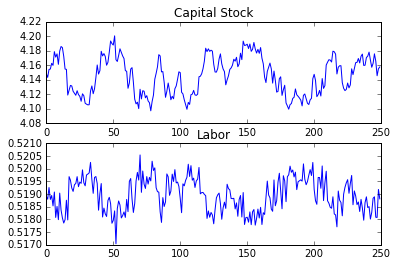

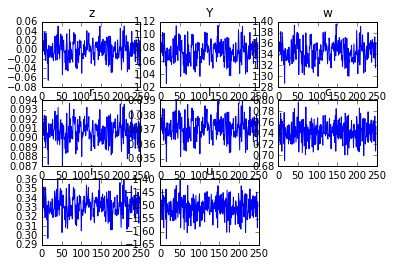

In [39]:
# generate a history of Z's
nobs = 250
Zhist = np.zeros((nobs,1))
for t in range(1, nobs):
    Zhist[t,0] = rho_z*Zhist[t,0] + sigma_z*np.random.normal(0., 1.)
    
# put SS values and starting values into numpy vectors
XYbar = np.array([kbar, ellbar])
X0 = np.array([kbar])
Y0 = np.array([ellbar])

# simulate the model
khist, ellhist = \
    LinApp_SSL(X0, Zhist, XYbar, logX, PP, QQ, UU, Y0, RR, SS, VV)
    
# plot k and ell
plt.subplot(2, 1, 1)
plt.plot(khist)
plt.title('Capital Stock')
plt.subplot(2, 1, 2)
plt.plot(ellhist)
plt.title('Labor')
plt.show()

# find other variables and plot
# preallocate histories
Yhist = np.zeros(nobs-1)
whist = np.zeros(nobs-1)
rhist = np.zeros(nobs-1)
Thist = np.zeros(nobs-1)
chist = np.zeros(nobs-1)
ihist = np.zeros(nobs-1)
uhist = np.zeros(nobs-1)
for t in range(0, nobs-1):
    Yhist[t], whist[t], rhist[t], Thist[t], chist[t], ihist[t], uhist[t] = \
        Modeldefs(khist[t+1], khist[t], ellhist[t], Zhist[t], params)
        
plt.subplot(3, 3, 1)
plt.plot(Zhist)
plt.title('z')

plt.subplot(3, 3, 2)
plt.plot(Yhist)
plt.title('Y')

plt.subplot(3, 3, 3)
plt.plot(whist)
plt.title('w')

plt.subplot(3, 3, 4)
plt.plot(rhist)
plt.title('r')

plt.subplot(3, 3, 5)
plt.plot(Thist)
plt.title('T')

plt.subplot(3, 3, 6)
plt.plot(chist)
plt.title('c')

plt.subplot(3, 3, 7)
plt.plot(ihist)
plt.title('i')

plt.subplot(3, 3, 8)
plt.plot(uhist)
plt.title('u')

plt.show()

## Allowing for Policy Change

Rather than simulate about the same steady state for our whole simulation, we are going to change parameter values in the middle.  In addition we want to simulate several Monte Carlos for our model.  This means we cannot use `LinApp_SSL`, and will need to build our own history-generating function.  Fortuneately, we can still use `LinApp_Sim`, which generates next period's values of $X$ given today's state.

Our first tast is to specify new parameter values that will be put into place when the policy changes.  We then need to solve for the new steady state and the new linear coefficients.

In [41]:
# set new tax rate
tau2 = .10

# make parameter list to pass to functions
params2 = (alpha, beta, gamma, delta, chi, theta, tau2, rho_z, sigma_z)

# find new steady state
# use the old steady state values of k and ell for our guess
guessXY = XYbar

# find the steady state values using LinApp_FindSS
XYbar2 = LinApp_FindSS(Modeldyn, params2, guessXY, Zbar, nx, ny)
(kbar2, ellbar2) = XYbar2

# set up steady state input vector
theta02 = np.array([kbar2, kbar2, kbar2, ellbar2, ellbar2, 0., 0.])

# check SS solution
check = Modeldyn(theta02, params2)
print ('check SS: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')
    
# find the steady state values for the definitions
Ybar2, wbar2, rbar2, Tbar2, cbar2, ibar2, ubar2 = \
    Modeldefs(kbar2, kbar2, ellbar2, 0., params2)

# display all steady state values
print ('kbar:   ', kbar2)
print ('ellbar: ', ellbar2)
print ('Ybar:   ', Ybar2)
print ('wbar:   ', wbar2)
print ('rbar:   ', rbar2)
print ('Tbar:   ', Tbar2)
print ('cbar:   ', cbar2)
print ('ibar:   ', ibar2)
print ('ubar:   ', ubar2)

# find the new derivatives matrices
[AA2, BB2, CC2, DD2, FF2, GG2, HH2, JJ2, KK2, LL2, MM2, WW2, TT2] = \
    LinApp_Deriv(Modeldyn, params2, theta02, nx, ny, nz, logX)
    
# find the policy and jump function coefficients
PP2, QQ2, UU2, RR2, SS2, VV2 = \
    LinApp_Solve(AA2,BB2,CC2,DD2,FF2,GG2,HH2,JJ2,KK2,LL2,MM2,WW2,TT2,NN,Zbar,Sylv)
print ('P: ', PP2)
print ('Q: ', QQ2)
print ('R: ', RR2)
print ('S: ', SS2)

check SS:  [  1.11022302e-15   2.22044605e-16]
kbar:    4.14795450215
ellbar:  0.518907905124
Ybar:    1.07411450372
wbar:    1.34546885974
rbar:    0.0906326422116
Tbar:    0.0371139071775
cbar:    0.742278143551
ibar:    0.331836360172
ubar:    -1.50820490253
P:  [[ 0.9229589]]
Q:  [[ 0.53763674]]
R:  [[-0.02327817]]
S:  [[ 0.01206446]]


Now we write a function that will generate a random history of $Z$s and simulate, but which switches tax rates in period $t_s$.

In [83]:
def PolSim(initial, nobs, ts, coeffs1, state1, params1, coeffs2, state2, params2):
    from LinApp_Sim import LinApp_Sim
    '''
    Generates a history of k & ell with a switch in regime in period ts.
    
    Inputs
    -----------    
    initial: list of values for k & z (k0, z0) in the first period.
    nobs: number of periods to simulate.
    ts: period in which the shift occurs.
    coeffs1: list of (PP, QQ, UU, RR, SS, VV) under the baseline regime.
    state1: numpy array of XYbar under the baseline regime.
    params1: list of parameters under the baseline regime.
    coeffs2: list of (PP2, QQ2, UU2, RR2, SS2, VV2) under the new regime.
    state2: numpy array of XYbar2 under the new regime.
    params2: list of parameters under the new regime.
    
    Returns
    --------
    khist: 2D-array, dtype=float
        nobs-by-1 matrix containing the values of k
    
    ellhist: 2D-array, dtype=float
        nobs-by-1 matrix vector containing the values of ell 
        
    zhist: 2D-array, dtype=float
        nobs-by-1 matrix vector containing the values of z 
    '''
    
    # preallocate k, ell, and z
    khist = np.zeros(nobs+1)
    ellhist = np.zeros(nobs)
    zhist = np.zeros(nobs)
    
    # set starting values
    khist[0] = k0
    zhist[0] = z0
    
    # generate history of random shocks
    for t in range(1, nobs):
        zhist[t] = rho_z*zhist[t] + sigma_z*np.random.normal(0., 1.)
        
    # generate histories for k and ell for the first ts-1 periods
    for t in range(0, ts-1):
        # inputs must be 1D numpy arrays and deviation from SS values
        kin = np.array([khist[t] - kbar])
        zin = np.array([zhist[t]])
        k, ell = LinApp_Sim(kin, zin, PP, QQ, UU, RR, SS, VV)
        # k and ell are deviations from SS values, so add these back.
        # they are also 1D numpy arrays, so pull out the values rather than use the arrays.
        khist[t+1] = k[0] + kbar
        ellhist[t] = ell[0] + ellbar
    
    for t in range(ts-1, nobs):
        kin = np.array([khist[t] - kbar])
        zin = np.array([zhist[t]])
        k, ell = LinApp_Sim(kin, zin, PP, QQ, UU, RR, SS, VV)
        khist[t+1] = k + kbar
        ellhist[t] = ell + ellbar
    
    return khist, ellhist, zhist

We also write a function that takes the histories for $k$, $\ell$ and $z$ and returns the histories for the other variables.

In [84]:
def Other(khist, ellhist, zhist, params):
    # find the number of observations
    nobs = zhist.size
    
    # preallocate histories
    Yhist = np.zeros(nobs)
    whist = np.zeros(nobs)
    rhist = np.zeros(nobs)
    Thist = np.zeros(nobs)
    chist = np.zeros(nobs)
    ihist = np.zeros(nobs)
    uhist = np.zeros(nobs)
    
    for t in range(0, nobs):
        Yhist[t], whist[t], rhist[t], Thist[t], chist[t], ihist[t], uhist[t] = \
            Modeldefs(khist[t+1], khist[t], ellhist[t], Zhist[t], params)
    
    return Yhist, whist, rhist, Thist, chist, ihist, uhist

We need to simulate this model `nsim` times and save the histories of all the variable each time.  

In [100]:
# specify the number of simulations and observations per simulation
nsim = 100
nobs = 60

# specify the period policy shifts
ts = 20

# specify initial values
k0 = kbar
z0 = 0.
initial = (k0, z0)

# set up coefficient lists
coeffs1 = (PP, QQ, UU, RR, SS, VV)
coeffs2 = (PP2, QQ2, UU2, RR2, SS2, VV2)

# begin Monte Carlos

# run first simulation and store in Monte Carlo matrices
kmc, ellmc, zmc = PolSim(initial, nobs, ts, coeffs1, XYbar, params, coeffs2, XYbar2, params2)
Ymc, wmc, rmc, Tmc, cmc, imc, umc = Other(kmc, ellmc, zmc, params)

for i in range(1, nsim):
    # run remaining simulations
    khist, ellhist, zhist = \
        PolSim(initial, nobs, ts, coeffs1, XYbar, params, coeffs2, XYbar2, params2)
    Yhist, whist, rhist, Thist, chist, ihist, uhist = \
        Other(khist, ellhist, zhist, params)
    
    # stack results in Monte Carlo matrices
    kmc = np.vstack((kmc, khist))
    ellmc = np.vstack((ellmc, ellhist))
    zmc = np.vstack((zmc, zhist))
    Ymc = np.vstack((Ymc, Yhist))
    wmc = np.vstack((wmc, whist))
    rmc = np.vstack((rmc, rhist))
    wmc = np.vstack((wmc, whist))
    Tmc = np.vstack((Tmc, Thist))
    cmc = np.vstack((cmc, chist))
    imc = np.vstack((imc, ihist))
    umc = np.vstack((umc, uhist))

Now we sort these over simulations and find the confidence bands for the histories.

In [101]:
    
# now sort the Monte Carlo matrices over the rows
kmc = np.sort(kmc, axis = 0)
ellmc = np.sort(ellmc, axis = 0)
zmc = np.sort(zmc, axis = 0)
Ymc = np.sort(Ymc, axis = 0)
wmc = np.sort(wmc, axis = 0)
rmc = np.sort(rmc, axis = 0)
Tmc = np.sort(Tmc, axis = 0)
cmc = np.sort(cmc, axis = 0)
imc = np.sort(imc, axis = 0)
umc = np.sort(umc, axis = 0)

# find the average values for each variable in each time period across Monte Carlos
kavg = np.mean(kmc, axis = 0)
ellavg = np.mean(ellmc, axis = 0)
zavg = np.mean(zmc, axis = 0)
Yavg = np.mean(Ymc, axis = 0)
wavg = np.mean(wmc, axis = 0)
ravg = np.mean(rmc, axis = 0)
Tavg = np.mean(Tmc, axis = 0)
cavg = np.mean(cmc, axis = 0)
iavg = np.mean(imc, axis = 0)
uavg = np.mean(umc, axis = 0)

# find the rows for desired confidence bands
conf = .1
low = int(np.floor((conf/2)*nsim))
high = nsim - low

# find the upper and lower confidence bands for each variable
kupp = kmc[high,:]
ellupp = ellmc[high,:]
zupp = zmc[high,:]
Yupp = Ymc[high,:]
wupp = wmc[high,:]
rupp = rmc[high,:]
Tupp = Tmc[high,:]
cupp = cmc[high,:]
iupp = imc[high,:]
uupp = umc[high,:]

klow = kmc[low,:]
elllow = ellmc[low,:]
zlow = zmc[low,:]
Ylow = Ymc[low,:]
wlow = wmc[low,:]
rlow = rmc[low,:]
Tlow = Tmc[low,:]
clow = cmc[low,:]
ilow = imc[low,:]
ulow = umc[low,:]

5 95


Finally we plot the mean value and confidence bands.

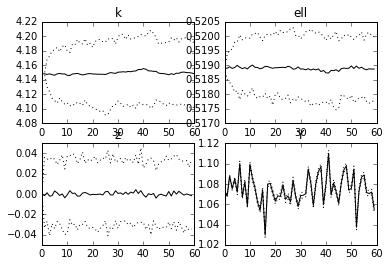

In [102]:
# plot
plt.subplot(2,2,1)
plt.plot(range(kavg.size), kavg, 'k-',
         range(kupp.size), kupp, 'k:',
         range(klow.size), klow, 'k:')
plt.title('k')

plt.subplot(2,2,2)
plt.plot(range(ellavg.size), ellavg, 'k-',
         range(ellupp.size), ellupp, 'k:',
         range(elllow.size), elllow, 'k:')
plt.title('ell')

plt.subplot(2,2,3)
plt.plot(range(zavg.size), zavg, 'k-',
         range(zupp.size), zupp, 'k:',
         range(zlow.size), zlow, 'k:')
plt.title('z')

plt.subplot(2,2,4)
plt.plot(range(Yavg.size), Yavg, 'k-',
         range(Yupp.size), Yupp, 'k:',
         range(Ylow.size), Ylow, 'k:')
plt.title('Y')

plt.show()